### **Using the trained model on the random Test set**

**Importing all the important libraries**

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import PIL.ImageOps
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

torch.manual_seed(42)

**Function for displaying the images.**

In [ ]:
##--Function to show the images
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration, loss)
    plt.show()


**Function to access the train and test folders easily**

In [ ]:
## To access the train and test folders easily
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"

***Function to generate randomly selected pair of images from any of the folders(training or testing).***

In [ ]:
## Image pair generation function by random selection from the Image-folder. And further processing the images to make it workable with the torch model.
class workingDataset(Dataset):

    # this is invoked when the object is created
    def __init__(self, imageFolderDataset, transform=None, should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    # this is invoked when you loop through the datasets / iterating
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs) #(image-location, image class in the test set folder)
        img1_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_class = random.randint(0, 1) # 0 => genuine, 1 = imposter

        if should_get_same_class:
           while True:
               #keep looping till the same class image is found
               img1_tuple = random.choice(self.imageFolderDataset.imgs) #27
               if img0_tuple[1]==img1_tuple[1]:
                   break
        else:
           while True:
               #keep looping till a different class image is found
               img1_tuple = random.choice(self.imageFolderDataset.imgs)
               if img0_tuple[1] != img1_tuple[1]:
                   break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)


        # img0, img1, label 0 (genuine) / 1 (imposter)
        return img0, img1

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

**Loading the torch model, trained with AT & T dataset to Quantify the amount of dissimilarity between a pair of images.**


**Note** - I used ***torch.jit.script()*** to save my trained model. Since this allowed me to retain the model's its class/architecture information, which is necessary for later uses without any need to write again the code for model's class/architecture.

In [ ]:
model = torch.jit.load('model_scripted_image_dissimilarity.pt')

#### **Applying my trainied model to give the disimilarity index (which is essentially the Euclidean-distance) between the two random image pairs selected from the Test-dataset.**

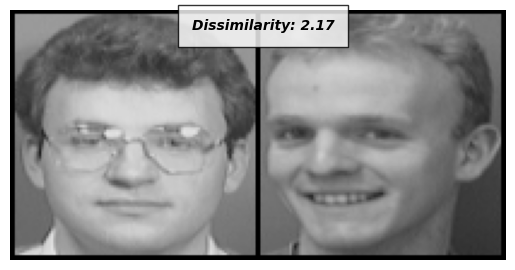

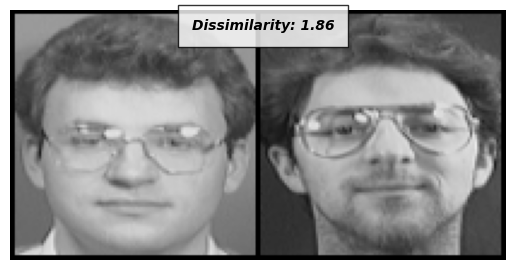

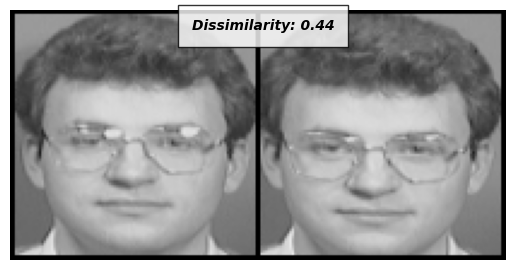

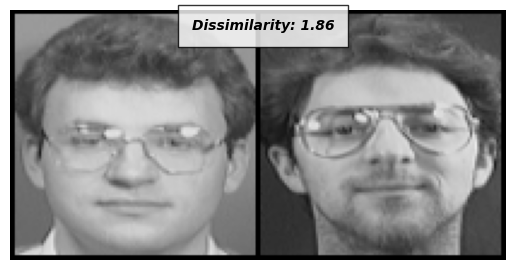

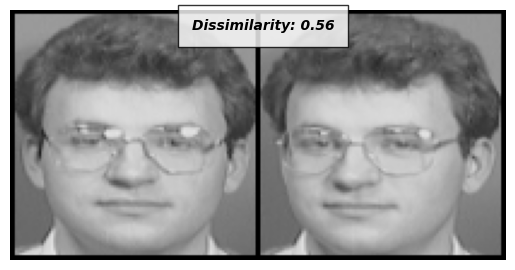

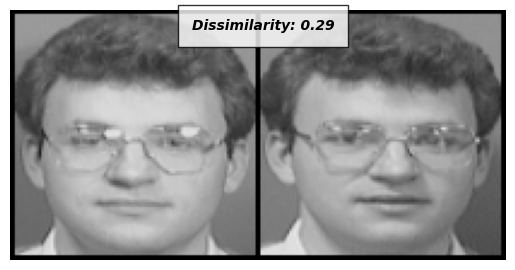

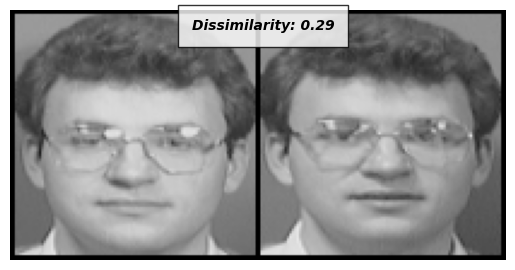

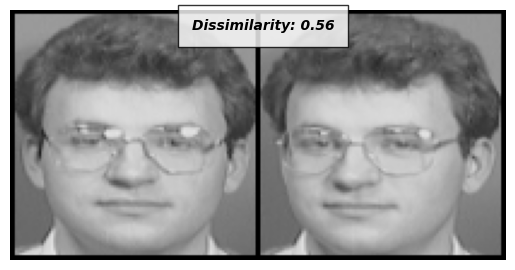

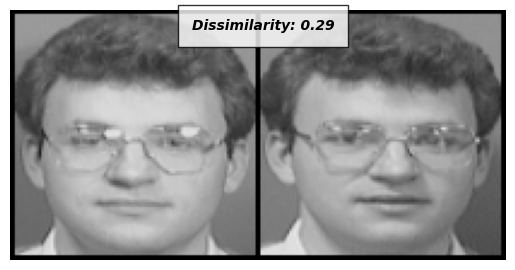

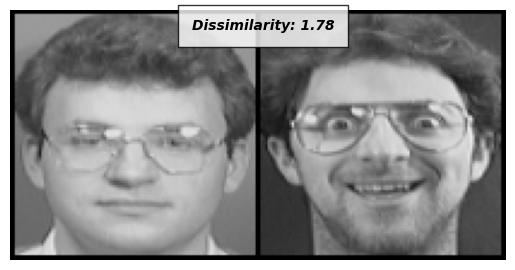

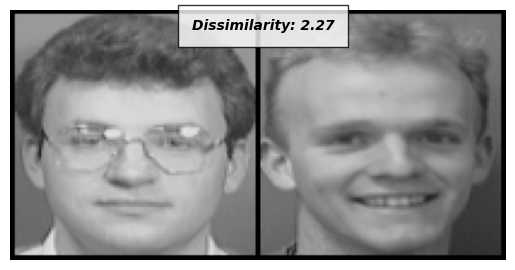

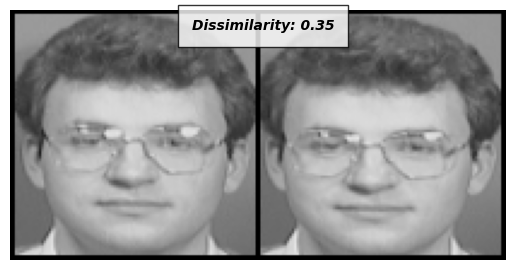

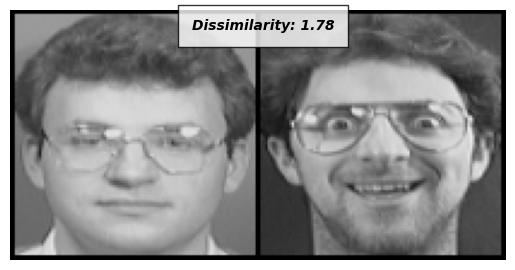

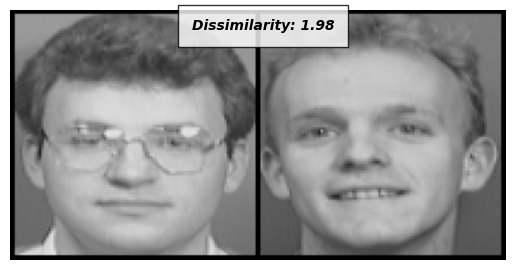

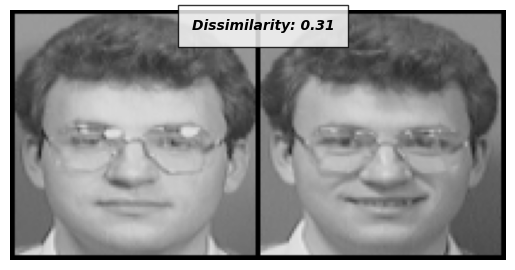

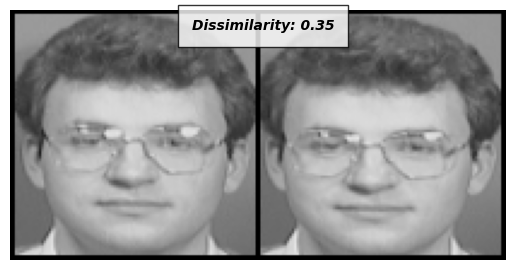

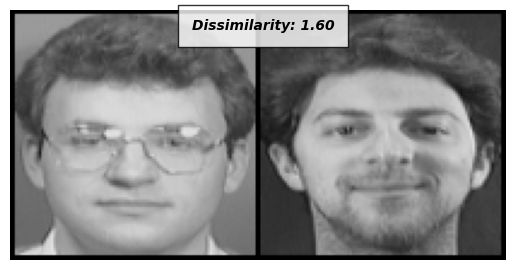

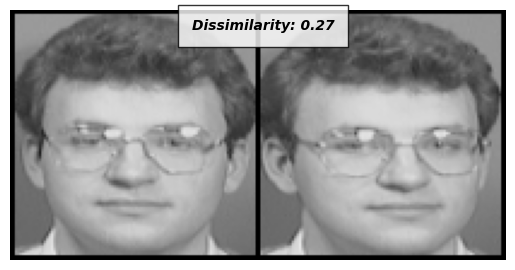

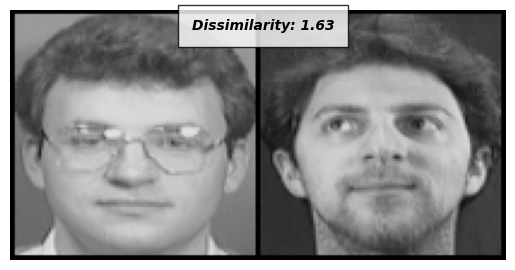

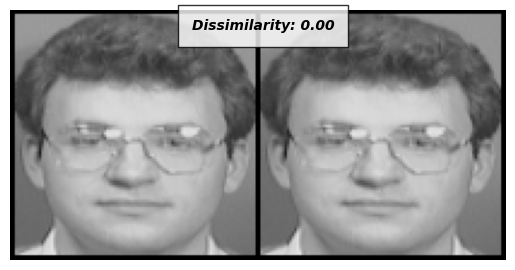

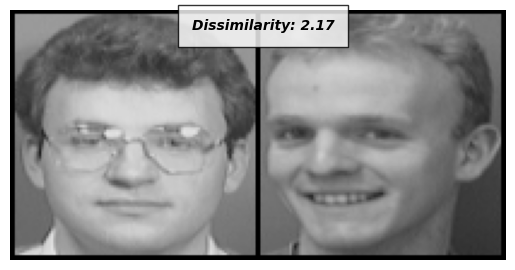

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
image_dataset = workingDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose(
    [transforms.Resize((100,100)),transforms.ToTensor()]), should_invert=False)

test_dataloader = DataLoader(image_dataset,num_workers=4,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
next(dataiter)
x0,_ = next(dataiter)
for i in range(21):        # i am iterating the image-pair generator function for 21 times.
    _,x1 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    #output1,output2 = model(Variable(x0).cuda(),Variable(x1).cuda())
    output1,output2 = model(Variable(x0),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1,output2) #similarity metric
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

**The number visible on each image-pair denotes the degree of dissimilarity my trained model found between those two images. Lesser the number denoting the dissimilarity means less dissimilar (or more similar images), while higher values greater the dissimilarity. For the exact same image-pair the dissimilarity=0**